## Ⅰ. Intro

### 1. 테이블의 내용
1. 고객이 각 귀속년도별
1. 근로 / 사업 / 기타 소득에 대한 예상환급액과 수수료를 조회한 뒤
1. 결제를 하거나 하지 않은 여부를 저장

### 2. 컬럼 정보
- age: 고객의 만 나이입니다. 
- gender: 고객의 성별입니다.
- year: 소득이 발생한 연도(귀속년도)입니다.
- refund: 예상환급액입니다.
- fee: 수수료입니다.
- has_paid: 수수료를 결제했는지의 여부
- income_근로: 고객의 근로소득(월급/일용직급여)
- income_사업: 고객의 사업소득(프리랜서 소득)
- income_기타: 고객의 기타소득(그외 기타 소득)

### 3. 질문

- 고객의 결제여부에 영향을 미치는 요인들은 무엇인가요? 
- 고객의 수수료 결제금액의 합을 높히기 위해서는 어떻게 해야 할까요?

### 4. 개념파악 
- 납부세액 혹은 환급세액의 결정방법
    소득을 3범주로 하여, 기장의무가 달라진다.  
<https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=fobi52&logNo=221270380307>

### 5. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df=pd.read_csv('Jobis_3o3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
age          100000 non-null float64
gender       100000 non-null object
year         100000 non-null int64
refund       100000 non-null float64
fee          100000 non-null float64
has_paid     100000 non-null bool
income_근로    40791 non-null float64
income_사업    78227 non-null float64
income_기타    25260 non-null float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


In [4]:
df.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타
count,100000.00000,100000.000000,1.000000e+05,100000.000000,4.079100e+04,7.822700e+04,2.526000e+04
mean,29.00096,2018.111300,2.081422e+05,7247.641000,6.432597e+06,1.511712e+06,6.362834e+05
std,7.76819,1.495812,3.071744e+05,11926.896979,6.583716e+06,2.449810e+06,1.484947e+06
min,15.00000,2015.000000,-8.265000e+06,400.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,24.00000,2017.000000,3.300000e+04,400.000000,1.616000e+06,1.770000e+05,8.200000e+04
50%,27.00000,2018.000000,9.900000e+04,4300.000000,4.507000e+06,6.190000e+05,2.130000e+05
75%,31.00000,2019.000000,2.540000e+05,8500.000000,9.301000e+06,1.601000e+06,5.820000e+05
max,81.00000,2020.000000,7.725000e+06,307000.000000,1.823350e+08,3.993400e+07,6.281000e+07


#### 1) 지불여부를 숫자로 바꾸고 수수료를 곱한 새로운 변수(Target)를 생성한다.
#### 2) 환급액에서 수수료를 뺀 gain이라는 변수를 생성

In [5]:
df['has_paid']=df['has_paid'].astype('int')

In [6]:
df['Target']=df.has_paid*df.fee

#### 3) 환급액과 수수료를 고려한 순 환급액과 이익률 변수를 생성

In [7]:
gain=df.refund-df.fee
df['gain']=gain

#### 4) 나이를 카테고리화

- 나이를 카테고리화하는 기준으로는 사분위수를 사용한 값 범위를 활용하였다.  
    다만, 상위 이상값들의 결제금액합이 전체 데이터의 19%에 해당해 상위 이상값은 두그룹으로 나눴다.

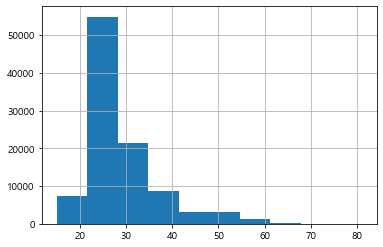

In [8]:
df.age.hist()

In [9]:
IQR= df.age.quantile(0.75)-df.age.quantile(0.25)
Q3= df.age.quantile(0.25)
Q1=df.age.quantile(0.75)

In [10]:
df.query("(age > @Q1-1.5*@IQR) and (age < @Q3+1.5*@IQR)").age.describe()

count    79872.000000
mean        26.467085
std          3.310020
min         21.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         34.000000
Name: age, dtype: float64

In [11]:
# 상위 이상값들의 총 결제금액에서 차지하는 비중(%) 
str(round((df.query("age > 34").Target.sum()/df.Target.sum())*100,2))+'%'

'19.56%'

In [12]:
# 하위
str(round((df.query("age < 21").Target.sum()/df.Target.sum())*100,2))+'%'

'2.45%'

In [13]:
df.query("age > 34").age.quantile(0.25)

37.0

In [14]:
df.query("age > 34").age.quantile(0.75)

48.0

In [15]:
# 나이 카테고리 변수 생성
cat_1=pd.cut(df.age,bins=[-1,21,24,26,29,34,37,48,100]).astype('str').str.rstrip(']').str.lstrip('(')
df['ag_cat']=cat_1

- 추가로 각 소득원의 유무와 각 데이터가 소득원을 몇개가지고 있는지도 변수로 생성한다.

In [16]:
df['근로yn']=df.income_근로.notnull()
df['사업yn']=df.income_사업.notnull()
df['기타yn']=df.income_기타.notnull()
df['소득notnull여부']=pd.concat([df.income_근로.notnull(),df.income_사업.notnull(),df.income_기타.notnull()],axis=1).sum(1).astype('str')

#### 5) 성별컬럼 결측값처리

In [17]:
df.gender.value_counts()

M    50477
F    49501
-       22
Name: gender, dtype: int64

- 성별 값이 '-'인 데이터는 22건이 존재한다. 그리고 모두 소득원에 대한 정보가 없다. (위 3가지 컬럼에 집계되지 않는 소득이 있는 것으로 판단한다.) 
- 이중 실제 결제 된 데이터가 4건에 해당한다. 이는, 총 결제데이터 6만4천건 정도의 데이터규모에서 극히 일부분이며, 결제 여부를 고려하지 않는 10만건 중에 성별 결측치 데이터는 22건으로 극 소수이기 때문에 제외한다.

In [18]:
df.loc[df.gender=='-',:]

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
2613,27.0,-,2016,559000.0,12800.0,0,NaN,NaN,NaN,0.0,546200.0,"26, 29",False,False,False,0
4101,27.0,-,2017,209000.0,4300.0,0,NaN,NaN,NaN,0.0,204700.0,"26, 29",False,False,False,0
9574,42.0,-,2015,175000.0,4300.0,0,NaN,NaN,NaN,0.0,170700.0,"37, 48",False,False,False,0
20536,26.0,-,2017,845000.0,25100.0,0,NaN,NaN,NaN,0.0,819900.0,"24, 26",False,False,False,0
28211,26.0,-,2016,650000.0,12800.0,0,NaN,NaN,NaN,0.0,637200.0,"24, 26",False,False,False,0
36217,27.0,-,2018,124000.0,3400.0,0,NaN,NaN,NaN,0.0,120600.0,"26, 29",False,False,False,0
37674,27.0,-,2015,252000.0,8500.0,0,NaN,NaN,NaN,0.0,243500.0,"26, 29",False,False,False,0
38223,53.0,-,2015,6000.0,400.0,0,NaN,NaN,NaN,0.0,5600.0,"48, 100",False,False,False,0
38441,23.0,-,2018,110000.0,3000.0,0,NaN,NaN,NaN,0.0,107000.0,"21, 24",False,False,False,0
41454,41.0,-,2015,122000.0,4300.0,1,NaN,NaN,NaN,4300.0,117700.0,"37, 48",False,False,False,0


In [19]:
df.query("(gender=='-') and (has_paid==1)")

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
41454,41.0,-,2015,122000.0,4300.0,1,NaN,NaN,NaN,4300.0,117700.0,"37, 48",False,False,False,0
47966,41.0,-,2017,35000.0,400.0,1,NaN,NaN,NaN,400.0,34600.0,"37, 48",False,False,False,0
53924,41.0,-,2016,179000.0,4300.0,1,NaN,NaN,NaN,4300.0,174700.0,"37, 48",False,False,False,0
60508,22.0,-,2018,33000.0,400.0,1,NaN,NaN,NaN,400.0,32600.0,"21, 24",False,False,False,0


In [20]:
df=df.loc[df.gender!='-',:]

- 환급세액이 마이너스인 경우의 제거여부

In [21]:
df.query("refund <0 and has_paid ==1.0")

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
10034,34.0,M,2015,-231000.0,8500.0,1,8989000.0,1714000.0,NaN,8500.0,-239500.0,"29, 34",True,True,False,2
10624,25.0,F,2018,-7000.0,400.0,1,7508000.0,28000.0,NaN,400.0,-7400.0,"24, 26",True,True,False,2
29515,41.0,F,2017,-10000.0,400.0,1,19718000.0,162000.0,128000.0,400.0,-10400.0,"37, 48",True,True,True,3
54256,48.0,F,2018,-948000.0,3000.0,1,8157000.0,3975000.0,NaN,3000.0,-951000.0,"37, 48",True,True,False,2
57756,38.0,F,2017,-107000.0,4300.0,1,16619000.0,737000.0,NaN,4300.0,-111300.0,"37, 48",True,True,False,2
68881,33.0,M,2016,-322000.0,400.0,1,NaN,57000.0,NaN,400.0,-322400.0,"29, 34",False,True,False,1
98352,33.0,M,2018,-8265000.0,4300.0,1,NaN,690000.0,NaN,4300.0,-8269300.0,"29, 34",False,True,False,1


- 환급세액이 마이너스인 경우는 기납부 세액이 결정세액보다 적은 경우이므로 세액의 특성상 존재하는 데이터이다.  
- 이 데이터들은 오류 데이터로 보지 않고 삭제하지 않는다. 또한 전체 데이터에서 수수료중 빈도수가 높은 400과 4300과 8500에 해당하는 데이터   이므로 대표성이 있다고 볼 수 있다.

#### 6) 상관관계 파악

In [22]:
corr=df.corr()

Text(0.5, 1, 'Feature Correlation')

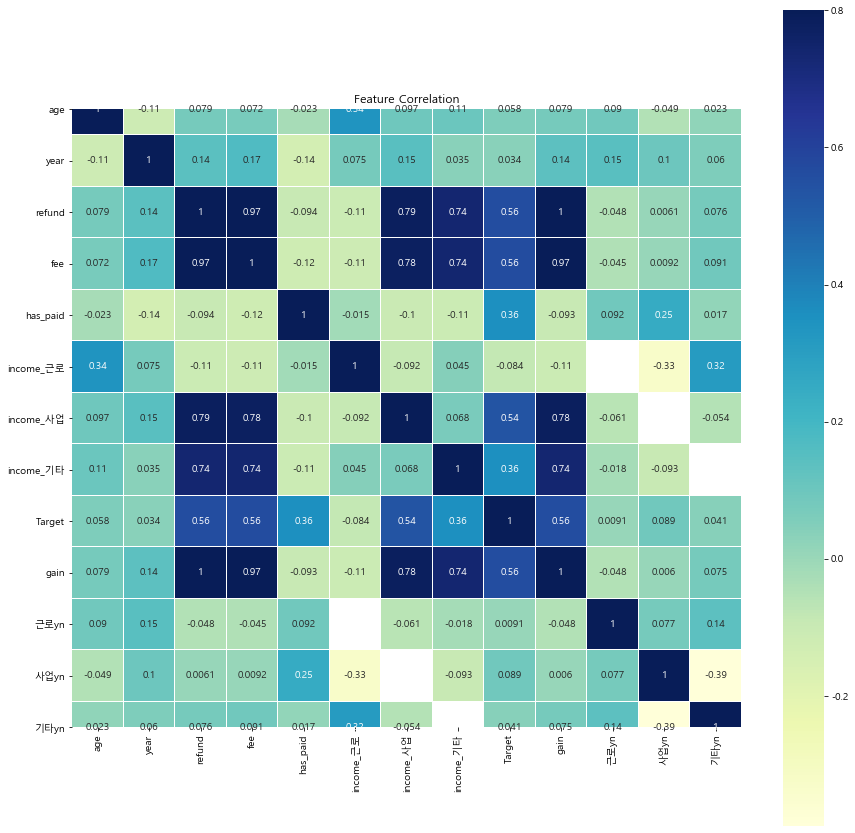

In [23]:
plt.figure(figsize=(15, 15));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation')

- <U>상관계수 히트맵으로는 결제여부는 약한 상관관계(0.25)가 있는 사업소득 유무를 제외하면,상관관계 있는 변수는 없는 것으로 판단된다.</U>
- 다만, 결제금액인 Target을 보면, 상식적으로 생각하는 것처럼 사업소득, 기타소득,환급액과 수수료에 상관관계가 있다.
- 추가로, 사업소득과 결제금액(Target)은 뚜렷한 양의 상관관계가 있으며, 기타소득과도 결제금액은 어느정도의 상관관계가 있다.

####  7) 범주형 변수간의 상관관계 파악
#### - Cramer's V
#####   범주형 변수간 상관관계 파악
#####   비교 대상 범주 대상이 3개 이상
https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

In [24]:
data = df[[i for i in df.columns if i in ('gender','ag_cat','has_paid','근로yn','사업yn','기타yn','소득notnull여부','year')]]

data.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,F,2019,0,"26, 29",True,True,False,2
1,M,2018,1,"29, 34",True,False,True,2
2,F,2017,0,"26, 29",False,True,False,1
3,M,2019,0,"26, 29",False,True,False,1
4,F,2016,1,"24, 26",True,True,False,2


In [25]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.columns :
  data_encoded[i]=label.fit_transform(data[i])

In [26]:
data_encoded.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,0,4,0,3,1,1,0,2
1,1,3,1,4,1,0,1,2
2,0,2,0,3,0,1,0,1
3,1,4,0,3,0,1,0,1
4,0,1,1,2,1,1,0,2


In [27]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [28]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df1 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df1

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
gender,1.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
year,0.00,1.00,0.04,0.01,0.03,0.02,0.01,0.03
has_paid,0.00,0.04,1.00,0.00,0.01,0.06,0.00,0.10
ag_cat,0.02,0.01,0.00,1.00,0.04,0.01,0.01,0.02
근로yn,0.00,0.03,0.01,0.04,1.00,0.01,0.02,0.76
사업yn,0.00,0.02,0.06,0.01,0.01,1.00,0.15,0.37
기타yn,0.00,0.01,0.00,0.01,0.02,0.15,1.00,0.26
소득notnull여부,0.00,0.03,0.10,0.02,0.76,0.37,0.26,1.00


Text(0.5, 1, 'Feature Correlation')

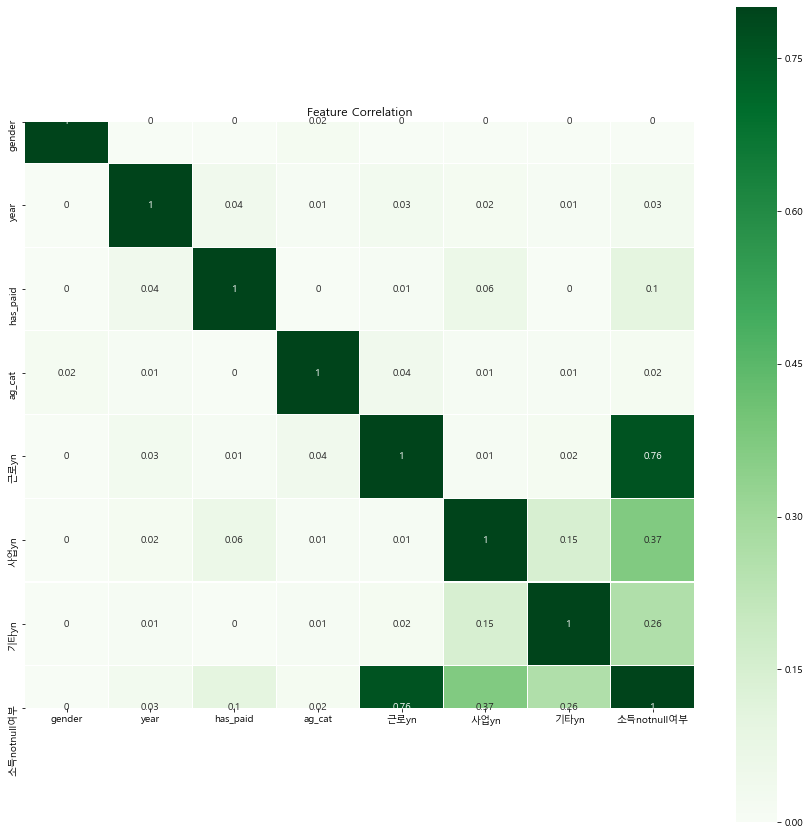

In [29]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(15, 15));
sns.heatmap(df1,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='Greens');
plt.title('Feature Correlation')

- <U>통계적으로 범주형 변수간의 상관관계는 없는 것으로 판단된다.</U>

***

## Ⅱ. 고객의 결제여부에 영향을 미치는 요인 과 총결제금액 합의 개선을 위한 분석

### 1. 머신러닝 분류 모델을 통해 지불여부에 대해 데이터를 학습시키고 feature importance를 출력한 후 분석을 진행
#### 1) XGB분류모델을 통해 지불여부를 target value로 설정하고, 나머지 변수를 학습

In [30]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [31]:
X=df.reindex(['gender','year', 'refund', 'fee','income_근로','income_사업', 'income_기타','gain','age'],axis=1)
X=X.fillna(0)

# 분류 목적 대상
y=df.has_paid

#인코딩
X=pd.get_dummies(X)
#스케일링
X.iloc[:,:8]=scaler.fit_transform(X.iloc[:,:8])
X

,year,refund,fee,income_근로,income_사업,income_기타,gain,age,gender_F,gender_M
0,0.8,0.517198,0.000000,0.054850,0.001528,0.000000,0.527427,0.181818,1,0
1,0.6,0.523139,0.004240,0.099224,0.000000,0.028897,0.533400,0.287879,0,1
2,0.4,0.534959,0.036204,0.000000,0.036585,0.000000,0.544823,0.196970,1,0
3,0.8,0.542527,0.051533,0.000000,0.061877,0.000000,0.552237,0.181818,0,1
4,0.2,0.524015,0.012720,0.000000,0.017253,0.000000,0.534126,0.166667,1,0
...,...,...,...,...,...,...,...,...,...,...
99995,0.8,0.535710,0.037508,0.000000,0.000000,0.010826,0.545562,0.181818,1,0
99996,0.8,0.521701,0.002935,0.000000,0.011594,0.000000,0.531959,0.712121,1,0
99997,1.0,0.517448,0.000000,0.043453,0.001352,0.000000,0.527682,0.136364,0,1
99998,0.8,0.519012,0.000000,0.000000,0.005108,0.000000,0.529275,0.136364,0,1


In [32]:
y

0        0
1        1
2        0
3        0
4        1
        ..
99995    1
99996    1
99997    0
99998    1
99999    1
Name: has_paid, Length: 99978, dtype: int32

In [33]:
xgb_clf=XGBClassifier(n_estimators=100,random_state=42,learning_rate=0.3,use_label_encoder=False)
xgb_clf.fit(X,y)

[16:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### 2) 변수중요도 파악

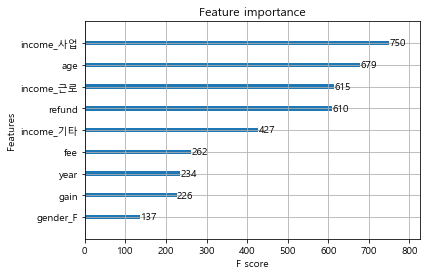

In [34]:
fig, ax = plt.subplots()
plot_importance(xgb_clf,ax=ax)

- 피어슨상관계수 히트맵에서 결제금액과 (사업소득 기타소득)이 상관관계가 있었는데, 여기서도 feature importance기준으로 상위에 속한다.
- 제일 높은 변수중요도를 가진 변수는 사업소득이고,두번쨰가 나이,3번째가 근로소득, 네번째가 환급액,5번째가 기타 소득에 해당한다.  
    => <U>이는 삼쩜삼 서비스를 이용해서 결제하는 주요 고객이 프리랜서일 수 있다는 의미로 해석할 수 있다.</U>
- 변수에 각 소득원의 유무(예: 근로yn)를 넣고 학습시켰을 때 소득원의 유무는 변수중요도가 높지 않았다. 

### 2. income 사업 변수 및 소득 데이터 분석
    - 그래프에서 보는 것처럼 결제고객의 사업소득 금액대 평균이 미결제고객의 금액대 보다 모든 연령그룹에서 훨씬 낮은 특징이 있다.
    - 다만, 최빈값을 기준으로 보면 다른 인사이트를 얻을 수 있다.  
    - 20세 이전과 26세에서 29세그룹, 34세부터 고연령층까지 사업소득의 최빈값이 구매고객 쪽이 더 높다.
    - 이를 사용하면 연령별로 income 소득의 최빈값을 기준으로하여 결제율을 상승시킬 수 있다.

#### 1) 연령별 결제여부별 각 소득 파악

#### (1) 사업소득

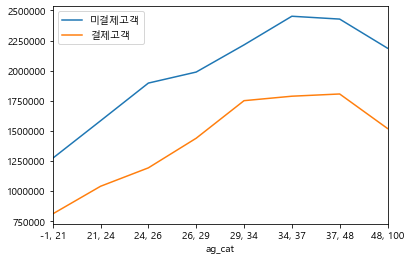

In [35]:
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

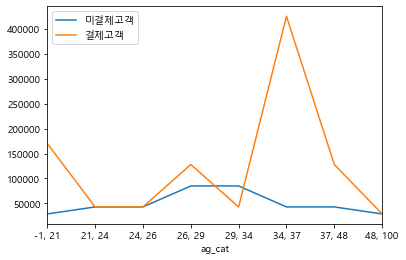

In [36]:
f1= lambda x: x.mode()
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

- 연령별 사업소득의 결제율을 높이기위한 값 설정

In [37]:
# 연령별 결제율
l1=[]
l2=[]
for i in df.ag_cat.unique():
    str_expr="ag_cat == @i"
    str_expr1="ag_cat == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
age_cvr=pd.DataFrame([l2,l1]).T
age_cvr.columns=['age_bin','cvr']
age_cvr=age_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_cvr

,cvr
age_bin,
"-1, 21",0.663146
"21, 24",0.653823
"26, 29",0.653374
"24, 26",0.652258
"29, 34",0.638193
"37, 48",0.625418
"34, 37",0.621988
"48, 100",0.616695


#### 사업소득 그룹화 (7개-> 6개와 null값)

In [38]:
inc_comp_cat=pd.cut(df.income_사업,bins=[-1,df.income_사업.quantile(0.17),df.income_사업.quantile(0.17*2),
                     df.income_사업.quantile(0.17*3),df.income_사업.quantile(0.17*4),df.income_사업.quantile(0.17*5),df.income_사업.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_comp_cat']=inc_comp_cat
df['inc_comp_cat']=df['inc_comp_cat'].astype('str')
df['inc_comp_cat']=df['inc_comp_cat'].replace('nan','n')
df

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,inc_comp_cat
0,27.0,F,2019,5000.0,400.0,0,10001000.0,61000.0,NaN,0.0,4600.0,"26, 29",True,True,False,2,"(-1.0, 102000.0]"
1,34.0,M,2018,100000.0,1700.0,1,18092000.0,NaN,1815000.0,1700.0,98300.0,"29, 34",True,False,True,2,n
2,28.0,F,2017,289000.0,11500.0,0,NaN,1461000.0,NaN,0.0,277500.0,"26, 29",False,True,False,1,"(1233000.0, 2793000.0]"
3,27.0,M,2019,410000.0,16200.0,0,NaN,2471000.0,NaN,0.0,393800.0,"26, 29",False,True,False,1,"(1233000.0, 2793000.0]"
4,26.0,F,2016,114000.0,4300.0,1,0.0,689000.0,NaN,4300.0,109700.0,"24, 26",True,True,False,2,"(640000.0, 1233000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27.0,F,2019,301000.0,11900.0,1,NaN,NaN,680000.0,11900.0,289100.0,"26, 29",False,False,True,1,n
99996,62.0,F,2019,77000.0,1300.0,1,NaN,463000.0,NaN,1300.0,75700.0,"48, 100",False,True,False,1,"(295000.0, 640000.0]"
99997,24.0,M,2020,9000.0,400.0,0,7923000.0,54000.0,NaN,0.0,8600.0,"21, 24",True,True,False,2,"(-1.0, 102000.0]"
99998,24.0,M,2019,34000.0,400.0,1,NaN,204000.0,NaN,400.0,33600.0,"21, 24",False,True,False,1,"(102000.0, 295000.0]"


<br></br>
#### 사업소득 그룹별 결제율을 측정 (3번째로 낮은 수치의 사업소득그룹이 결제율은 높음)

In [39]:
f1= lambda x : x/x.sum()
df.groupby(['inc_comp_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_comp_cat
(295000.0, 640000.0]       0.781172
(102000.0, 295000.0]       0.763988
(640000.0, 1233000.0]      0.746281
(1233000.0, 2793000.0]     0.704518
(-1.0, 102000.0]           0.642573
(2793000.0, 39934000.0]    0.605438
n                          0.420716
Name: 1, dtype: float64

#### 나이대별 결제율은 60%대 이므로, 70%대의 전환율을 가진 사업소득그룹중 최솟값을 기준으로 필터링 후 나이대별 결제율 측정

In [40]:
# 사업 소득 변수에 결제율 70%대의 최소값 이상인 데이터를 넣은 나이대별 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_buis_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_buis_cvr['age_cvr']=age_cvr
age_buis_cvr

,cvr,age_cvr
age_bin,,
"26, 29",0.738617,0.653374
"34, 37",0.731175,0.621988
"29, 34",0.727812,0.638193
"24, 26",0.727063,0.652258
"21, 24",0.716702,0.653823
"37, 48",0.710381,0.625418
"-1, 21",0.702544,0.663146
"48, 100",0.697194,0.616695


In [41]:
(age_buis_cvr-age_cvr).sort_values(by='cvr',ascending=False).mean()

age_cvr         NaN
cvr        0.078324
dtype: float64

- <U> xgboost 모델의 feature selection에서 높은 중요도를 보인 income_사업 소득의 필터링으로 결제여부에 영향을 미칠 수 있음을 확인했다.</U>

#### (2) 기타소득
    - 기타소득 그룹화

In [42]:
inc_etc_cat=pd.cut(df.income_기타,bins=[-1,df.income_기타.quantile(0.17),df.income_기타.quantile(0.17*2),
                     df.income_기타.quantile(0.17*3),df.income_기타.quantile(0.17*4),df.income_기타.quantile(0.17*5),df.income_기타.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_etc_cat']=inc_etc_cat
df['inc_etc_cat']=df['inc_etc_cat'].astype('str')
df['inc_etc_cat']=df['inc_etc_cat'].replace('nan','n')

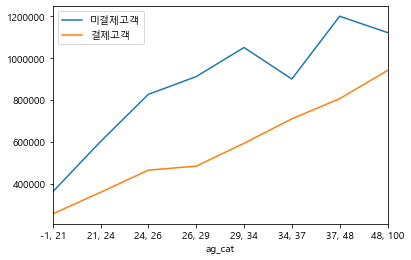

In [43]:
#기타소득 나이대별 평균
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

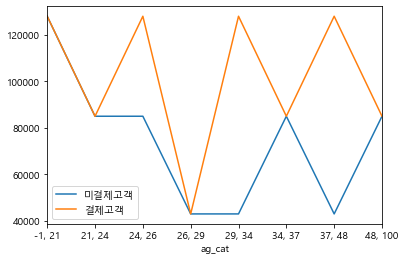

In [44]:
#기타소득 나이대별 최빈값
f1= lambda x: x.mode()[0]
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

In [45]:
f1= lambda x : x/x.sum()
df.groupby(['inc_etc_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_etc_cat
(51000.0, 114000.0]        0.690822
(114000.0, 213000.0]       0.688810
(-1.0, 51000.0]            0.686903
(213000.0, 425000.0]       0.682455
(425000.0, 1020000.0]      0.660925
n                          0.641813
(1020000.0, 62810000.0]    0.536968
Name: 1, dtype: float64

In [46]:
# 기타 소득 변수에 의한 필터링으로 나이대별 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_기타>= 51000 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_기타>= 51000 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_etc_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_etc_cvr['age_cvr']=age_cvr
age_etc_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.68244,0.663146
"21, 24",0.636502,0.653823
"24, 26",0.638557,0.652258
"26, 29",0.664028,0.653374
"29, 34",0.647432,0.638193
"34, 37",0.668863,0.621988
"37, 48",0.702674,0.625418
"48, 100",0.642029,0.616695


- 기타 소득의 경우 그래프와 위치기준 기타소득범위를 고려해 17%의 값으로 필터링하면, 21- 26세까지의 결제율은 낮아지고 나머지는 높아진다.
- <U>필터링 없는 경우와 비교하면  34세 이상의 결제율 상승에 기타소득을 최소값설정하여 필터링을 하는 것이 결제에 영향이 있다.</U> 

#### (3) 근로소득
    - 근로소득 범주화

In [47]:
inc_lab_cat=pd.cut(df.income_근로,bins=[-1,df.income_근로.quantile(0.17),df.income_근로.quantile(0.17*2),
                     df.income_근로.quantile(0.17*3),df.income_근로.quantile(0.17*4),df.income_근로.quantile(0.17*5),df.income_근로.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_lab_cat']=inc_lab_cat
df['inc_lab_cat']=df['inc_lab_cat'].astype('str')
df['inc_lab_cat']=df['inc_lab_cat'].replace('nan','n')

In [48]:
f1= lambda x : x/x.sum()
df.groupby(['inc_lab_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_lab_cat
(4651000.0, 7742000.0]       0.712329
(2457600.0, 4651000.0]       0.706561
(-1.0, 993300.0]             0.702523
(993300.0, 2457600.0]        0.700750
(7742000.0, 12228500.0]      0.698399
(12228500.0, 182335000.0]    0.673476
n                            0.610016
Name: 1, dtype: float64

In [49]:
# 근로 소득 카테고리에서 최소값기준으로 필터링하여 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_근로>= 1 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_근로>= 1 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_lab_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_lab_cvr['age_cvr']=age_cvr
age_lab_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.674883,0.663146
"21, 24",0.692552,0.653823
"24, 26",0.703427,0.652258
"26, 29",0.705387,0.653374
"29, 34",0.69557,0.638193
"34, 37",0.698121,0.621988
"37, 48",0.708914,0.625418
"48, 100",0.697551,0.616695


In [50]:
(age_lab_cvr['cvr']-age_lab_cvr['age_cvr']).mean()

0.05643869501667814

- 근로소득은 존재 여부의 필터링만이라도 모든 연령층에서 결제율 전환을 상승을 관찰할 수 있다.
- 그러므로, 근로소득도 결제여부에 영향을 주는 변수라고 볼 수 있다.
- 다만 차이값의 평균으로 보면 3가지 소득에서 전체를 동일기준으로 하면 사업 > 근로 > 기타 순으로 결제여부에 영향을 주는 것으로 추측할 수 있다.

### 3. AGE 변수 분석 

#### 1) 통계적 방법으로 독립성 검정을 통해 카테고리화한 나이 변수와 결제여부컬럼의 독립성을 확인한다.

- 독립성 검정은  두 factor 변수사이에 '귀무가설 : 독립이다. / 대립가설 : 독립이 아니다.' 를 의미한다.
- 카이제곱검정을 통한 P_value가 0.05보다 작으면 귀무가설은 기각되고 대립가설이 채택된다.  
- 주어진 데이터에서 나이카테고리와 지불여부에 대한 독립성검정시 pvalue가 0.05보다 작아 대립가설이 채택되고 서로 관련이 있다고 볼 수 있다.

In [51]:
from scipy.stats import chi2_contingency
df_age=pd.crosstab(df.ag_cat,df.has_paid)
p_value=chi2_contingency(df_age)[1]
(p_value,p_value<0.05)

(2.5428346424485214e-12, True)

#### 2) 데이터 그룹별 결제수 합과 결제율을 비교한다.

- 21-24세, 26-29세가 가장 결제 규모가 높고 34세까지는 높은 편에 속한다.
- age_cvr은 위에서 만든 나이별 전체 데이터의 결제율데이터이다.
- 결제율은 20세 이하의 데이터가 1등이기 때문에, 결제 규모의 순위와는 차이가 있다고 볼 수 있다.
- 하지만, 결제율을 비교하면 34세 이상의 나이가 하위권이고 그 이전의 나이대는 상위권인것처럼 전체적인 추세는 규모를 비교한 것과 비슷하다.
- <U>결국 21세 이상 34세 미만의 연령에 해당하는지의 여부가 결제여부에 영향을 미치는 것으로 볼 수 있다.</U>

In [52]:
# 나이대별 결제 데이터 수의 합을 보기 위한 것이다.
a=df.groupby('ag_cat')['has_paid'].sum().sort_values(ascending=False)
a

ag_cat
21, 24     14050
26, 29     13992
24, 26     11770
29, 34      9705
37, 48      4862
-1, 21      4835
34, 37      2891
48, 100     2534
Name: has_paid, dtype: int32

Text(0.5, 1.0, '나이대별 결제 데이터수의 합')

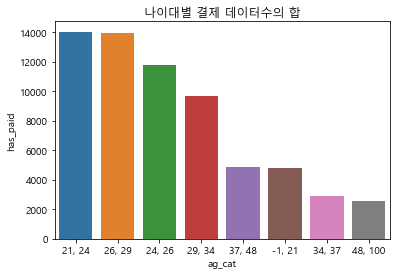

In [53]:
sns.barplot(x=a.index,y=a)
plt.title('나이대별 결제 데이터수의 합')

(0.5, 0.8)

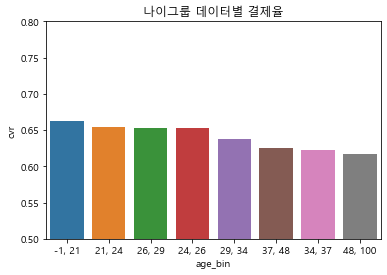

In [54]:
sns.barplot(age_cvr.index,age_cvr.cvr)
plt.title('나이그룹 데이터별 결제율')
plt.ylim(0.5, 0.8)

- 결제율과 나이대별 구매 규모를 고려한 변수 생성( 결제규모 x 결제율)
- 변수의 값을 보면, 34세 이전에 해당하는 그룹의 값과 아닌값의 차이가 약 2배 넘게 차이난다.
- 즉, <U>특정 연령 그룹에 해당하는지의 여부가 구매여부에 영향을 주는 것으로 파악된다.</U>

In [55]:
a2=(age_cvr[['cvr']].sort_index().transpose()*a.sort_index()).T
a2.columns=['variable']
a2.sort_values(by='variable',ascending=False)

,variable
age_bin,
"21, 24",9186.21
"26, 29",9142.01
"24, 26",7677.08
"29, 34",6193.66
"-1, 21",3206.31
"37, 48",3040.78
"34, 37",1798.17
"48, 100",1562.71


Text(0.5, 1.0, '나이그룹 데이터별 결제율과 결제수의 곱')

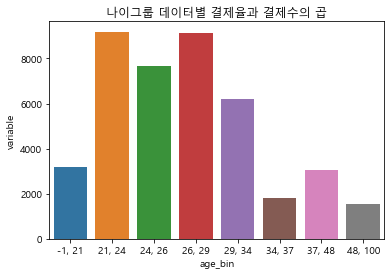

In [56]:
sns.barplot(a2.index,a2['variable'])
plt.title('나이그룹 데이터별 결제율과 결제수의 곱')

### 4. refund 변수 분석 
#### 1) 히스토그램을 통한 데이터 파악 및 범주화로 결제율 개선
    - 결제여부에 따라 환불액은 미결제 데이터가 1745개 결제데이터가 1521개로 차이가 있다.
    - 그리고 상위빈도 환불액의 경우, 크기차이가 있어 빈도수와 환불액을 곱한 수치의 합을 비교하겠다.
    - 이렇게 하면 높은 환불액에 빈도수가 높을 경우 더 높은 수치를 얻을 수 있다. 

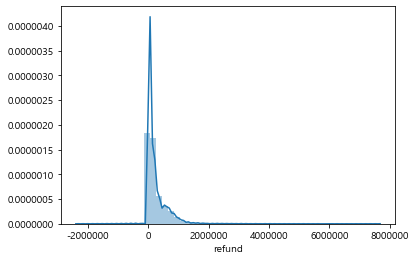

In [57]:
# 미결제 데이터의 환급액
sns.distplot(df.query("has_paid==0")['refund'],bins=50)

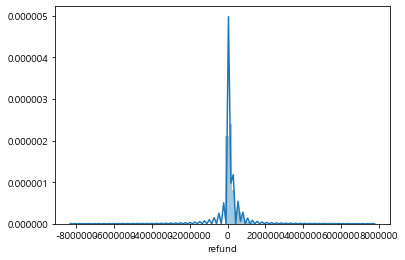

In [58]:
# 결제데이터의 환급액
sns.distplot(df.query("has_paid==1")['refund'],bins=100)

In [59]:
# 환불액을 3가지 범주 데이터로 변환
df=df.sort_values(by='refund')
l1=[]
for i in range(df.shape[0]):
    if i > df.shape[0]*0.66:
        l1.append('a')
    elif i > df.shape[0]*0.33:
        l1.append('b')
    else:
        l1.append('c')

df['ref_cat']=l1
df['ref_cat']

98352    c
52858    c
55168    c
54256    c
94281    c
        ..
30513    a
2374     a
47635    a
11235    a
61745    a
Name: ref_cat, Length: 99978, dtype: object

In [60]:
f1= lambda x: x/x.sum()
df.groupby(['ref_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1)

has_paid,0,1
ref_cat,,
a,0.391592,0.608408
b,0.308247,0.691753
c,0.359410,0.640590


In [61]:
(df.iloc[round(df.shape[0]*0.33),:].refund,df.iloc[round(df.shape[0]*0.66),:].refund)

(48000.0, 180000.0)

- 연령 데이터에서 b 그룹에 해당하는 refund 값으로 필터링하여 전체 연령 그룹의 결제율 개선확인
- <U> 즉, 환급액은 결제 여부에 영향을 미친다.</U>

In [62]:
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_ref_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_ref_cvr['age_cvr']=age_cvr
age_ref_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.731395,0.663146
"21, 24",0.703872,0.653823
"24, 26",0.694764,0.652258
"26, 29",0.69403,0.653374
"29, 34",0.668028,0.638193
"34, 37",0.650507,0.621988
"37, 48",0.676407,0.625418
"48, 100",0.663415,0.616695


In [63]:
# 환급금액 필터링을 통한 결제율 향상
(age_ref_cvr['cvr']-age_lab_cvr['age_cvr']).mean()

0.04469038955781765

### 5.  year변수분석과 결제금액 총합계 증대방안
#### 1)  연도에 따른 변화 분석

- 19년 이전까지는 연별 결제율이 감소하였는데, 특히 20년에 급감했다.
- 19년도 까지는 연도가 지나면서 결제 규모(결제데이터수)가 증가했으나 20년에 급감했다. 반면, 미결제 데이터 규모는 급증했다.
- 연도별 총 유입의 증가폭은 2019년까지 감소하다가 20년에 반등했다.
- 20년도는 미결제 데이터의 수는 금증하고 결제 데이터는 급감하였다.
- 19년부터 20년사이에 결제데이터의 수가 감소하고 예상환불액합계는 오히려 미결제자 측에서 급격히 증가하는 등 추세가 최근에 변하였다.

In [64]:
# 년도별 결제율 출력
l1=[]
l2=[]
for i in df.year.unique():
    str_expr="year == @i"
    str_expr1="year == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
y_cvr=pd.DataFrame([l2,l1]).T
y_cvr.columns=['year','cvr']
y_cvr=y_cvr.set_index('year').sort_values('cvr',ascending=False)
y_cvr

,cvr
year,
2015.0,0.711307
2017.0,0.697633
2016.0,0.697124
2018.0,0.695115
2019.0,0.694999
2020.0,0.485241


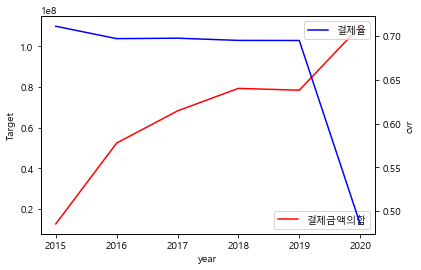

In [65]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(df.groupby('year')['Target'].sum().index,df.groupby('year')['Target'].sum(),label='결제금액의합',ax=ax1,color='red')
sns.lineplot(y_cvr.index,y_cvr['cvr'],label='결제율',ax=ax2,color='blue')
ax1.legend(loc="lower right")
ax2.legend()

- 결제데이터가 급격히 줄고, 미결제 데이터가 급격히 늘었으니 위 그래프 처럼 결제율이 급락하는 것은 당연하다.

Text(0.5, 1.0, '연도별 결제여부별 데이터의 수의 합계')

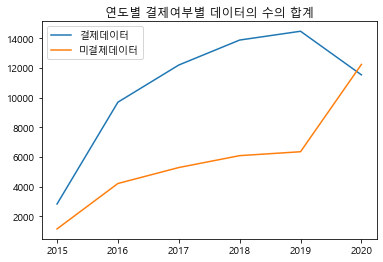

In [66]:
df_y_hp=df.groupby(['year','has_paid'])['age'].count()
df_y_hp.name='count'
df_y_hp=df_y_hp.reset_index()
df_y_hp1=df_y_hp.query("has_paid==1")
df_y_hp0=df_y_hp.query("has_paid==0")
plt.plot(df_y_hp1.year,df_y_hp1['count'],label='결제데이터')
plt.plot(df_y_hp0.year,df_y_hp0['count'],label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 데이터의 수의 합계')

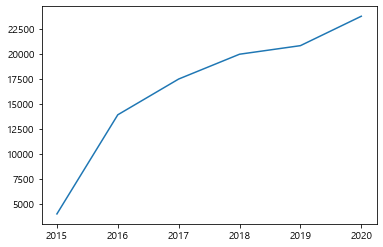

In [67]:
#연도별 총 유입의 증가폭
plt.plot(df.groupby('year')['age'].count().index,df.groupby('year')['age'].count())

In [68]:
#연도별 총 유입의 증가율
df.groupby('year')['age'].count().pct_change()

year
2015         NaN
2016    2.494975
2017    0.257513
2018    0.142122
2019    0.042947
2020    0.141390
Name: age, dtype: float64

- 이러한 구매고객의 감소가 고객들의 순 환급액의 감소가 아닐까 추정되어 이를 살펴보면 오히려 순환급액은 증가한다.
- 순환급액 때문에 2020년에 결제고객과 결제율이 급감한 것은 아니다.

Text(0.5, 1.0, '연도별 결제여부별 순 환급액의 평균')

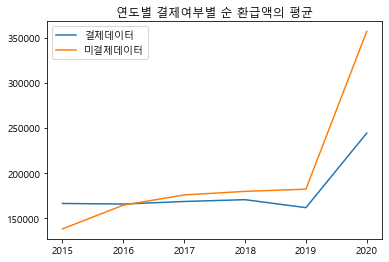

In [69]:
plt.plot(df.query("has_paid==1").groupby('year')['refund'].sum().index,df.query("has_paid==1").groupby('year')['gain'].mean(),label='결제데이터')
plt.plot(df.query("has_paid==0").groupby('year')['refund'].sum().index,df.query("has_paid==0").groupby('year')['gain'].mean(),label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 순 환급액의 평균')

Text(0.5, 1.0, '연도별 결제고객별 결제금액의 평균값')

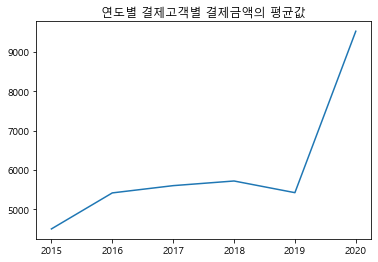

In [70]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].mean(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 평균값')

- 고객당 매출기여도는 20년도에 급격히 증가한다. 또한 총 고객의 연도별 결제금액의 합도 크게 증가한다.  
( 결제율과 결제고객수는 줄었는데, 고객 당 서비스를 통해 얻는 이익과 회사에 기여하는 평균 결제액, 총 결제액은 증가하였다.)

Text(0.5, 1.0, '연도별 결제고객별 결제금액의 총합계')

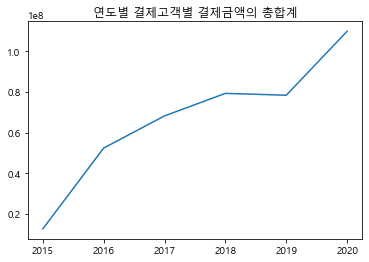

In [71]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].sum(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 총합계')

In [72]:
# 전년대비 결제금액의 총합계 증가율
df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].sum().pct_change()

(Int64Index([2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year'),
 year
 2015         NaN
 2016    3.123130
 2017    0.301403
 2018    0.162067
 2019   -0.011429
 2020    0.400863
 Name: Target, dtype: float64)

- 미결제 데이터의 수(낮아짐)와 결제 데이터의 수(높아짐)가 20년도에 교차되고 결제율이 급락하더라도 결제 금액총합은 지속적으로 증가한다.  
    -> <U>결제금액의 총합은 16년을 제외하면 2020년에 전년대비 증가 비율이 가장 높다.</U>  
    -> 즉, 이전년도와 비교하여 20년도의 어떠한 변화가 있었는지를 통해 총결제금액의 증대 방안을 유추할 수 있을 것이다.

#### 년도별 사업소득 그룹별로 차지하는 비중의 변화를 살펴보겠다.

Text(0.5, 66.5, '사업소득그룹별 분류')

C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46301 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanghyun\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47

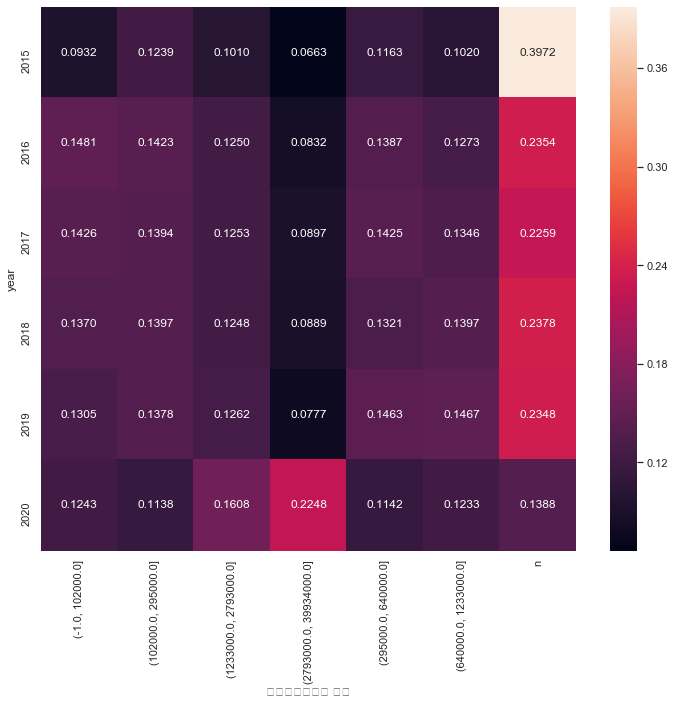

In [73]:
f1= lambda x: x / x.sum() 
tab=pd.crosstab(df.year,df.inc_comp_cat).apply(f1,axis=1)
sns.set(style='darkgrid')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)
ax.set_xlabel('사업소득그룹별 분류')

- 20년이되어, 사업소득이 없는 데이터가 23%대에서 13%대로 급감하고, 사업소득이 2,793,000 에서 39,934,000 범위인 데이터가 약 2.9배 높아졌다.
- 그외, 사업 소득이 1233000에서 2793000까지에 속한 그룹의 데이터 비중도 증가했다.

#### 년도별 근로소득과 기타소득 그룹별로 차지하는 비중의 변화를 살펴보겠다.

(6, 0)

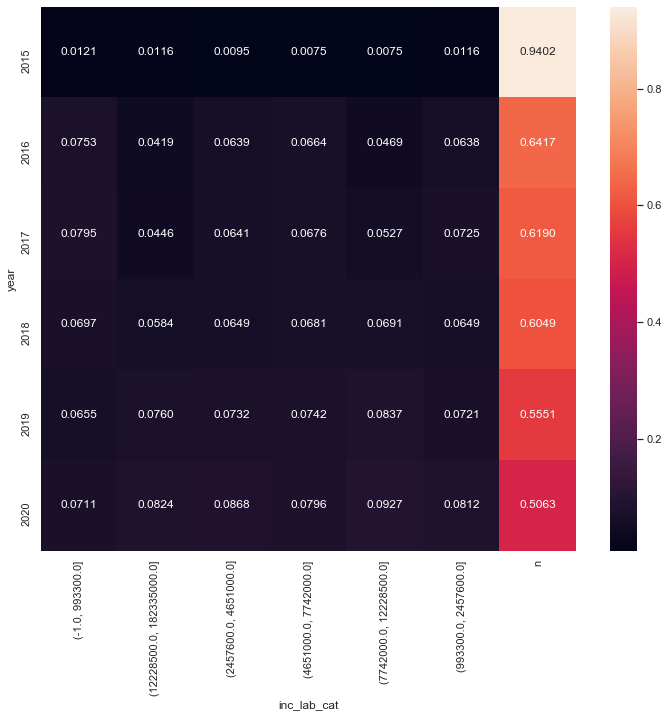

In [74]:
tab=pd.crosstab(df.year,df.inc_lab_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)

(6, 0)

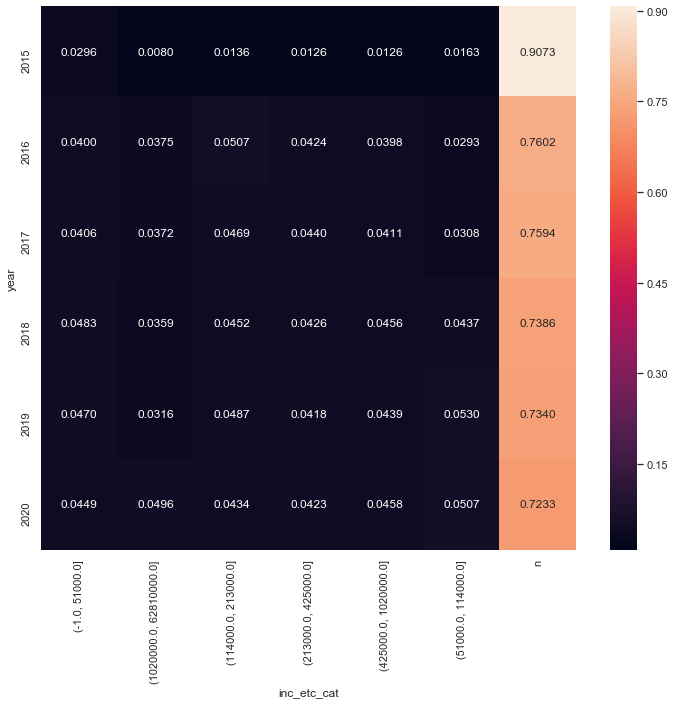

In [75]:
tab=pd.crosstab(df.year,df.inc_etc_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(12,10))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)

- 근로소득의 경우나 기타소득의 경우에는 이에 비해 결측값 감소나 특정그룹의 비율 변화정도가 작은편이다.

#### 년도별 환급액 그룹별로 차지하는 비중의 변화를 살펴보겠다.

(6, 0)

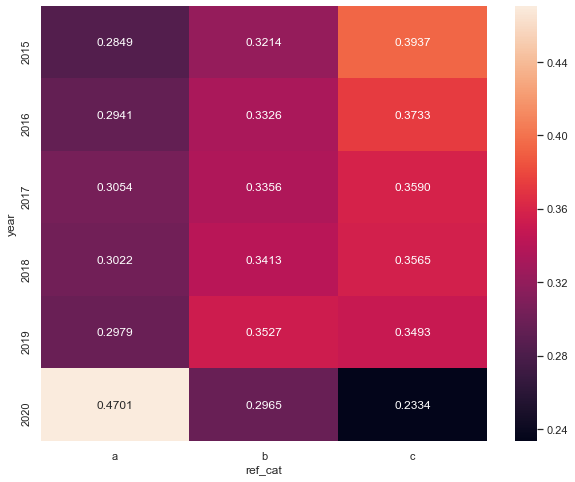

In [76]:
tab=pd.crosstab(df.year,df.ref_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)

- <U>2020년에는 환급액 각 그룹별 비중은 환급액이 제일 높은 그룹인 a그룹으로 편중되어 사업소득처럼 큰 변화가 있었다.</U>  
    ('a'그룹 : 환급액 크기 기준 66% 이상 데이터, 'b'그룹 : 환급액 크기 기준 33%이상 66% 미만 데이터, 'c'그룹 : 환급액 크기 기준 33%미만데이터)  
- 반면, 제일 저액의 그룹인 c그룹(약 11%)이 가장 많이 감소하고 중간액의 그룹은 덜 감소하였다.

#### 년도별 나이 그룹별로 차지하는 비중의 변화를 살펴보겠다.

(6, 0)

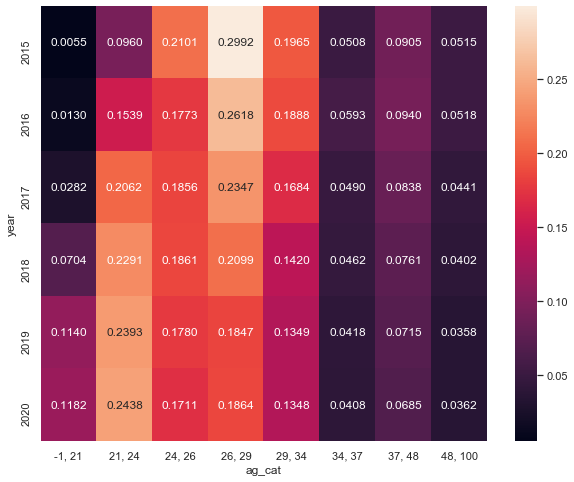

In [77]:
tab=pd.crosstab(df.year,df.ag_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(6,0)

- 19년과 20년 사이의 나이그룹의 변화는 거의 없는것으로 보인다.

#### 소득이 2793000 - 39934000(최고액 그룹)의 범위의 그룹이 2020년에 급증하였으므로 이를 다른그룹과의 비교해보겠다.

#### 사업소득 분류별로 나이대별 차지하는 비중
    
    사업소득 최고액 그룹은 26세 이상의 각 나이 그룹에 해당하는 데이터의 비중이 다른 소득 그룹보다 높다는 것을 알 수 있다.

(7, 0)

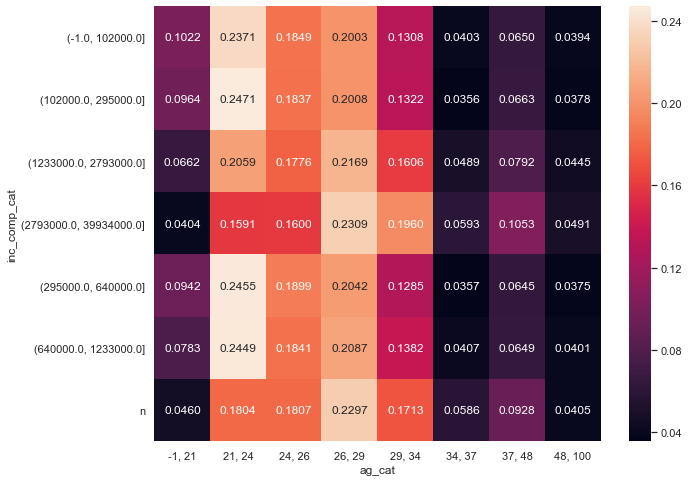

In [78]:
tab=pd.crosstab(df.inc_comp_cat,df.ag_cat).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)

#### 사업소득 카테고리의 최고액 그룹의 성비

(7, 0)

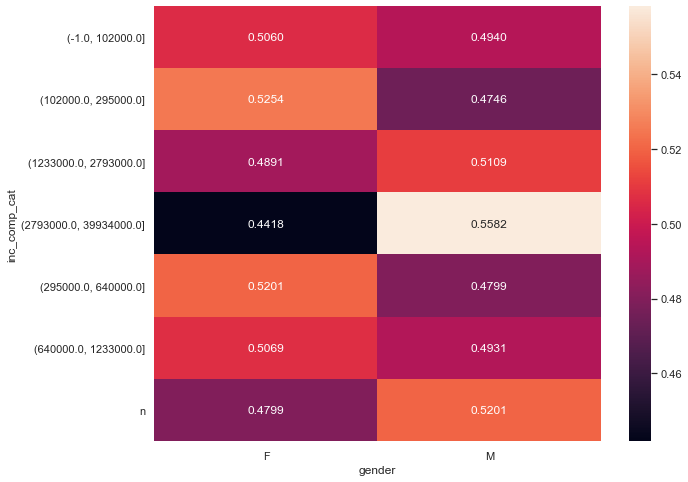

In [79]:
tab=pd.crosstab(df.inc_comp_cat,df.gender).apply(f1,axis=1)
sns.set(style='dark')
plt.figure(figsize=(10,8))
ax=sns.heatmap(tab,annot=True,fmt='.04f')
ax.set_ylim(7,0)

- 사업소득의 최상위 그룹의 성비차이가 가장 크고, 그 바로 밑의 사업소득 기준 상위 그룹도 성비차이가 다소 발생한다.

#### 이상의 내용을 바탕으로 결제급액의 결제금액의 총합을 증가시키기 위해 다음의 결론을 내릴 수 있다.
    1. 2020년에 총 결제율과 결제데이터의 수는 크게 하락하였으나 결제금액의 평균값과 총합계가 급증했다.
    2. 2020년에 사업소득이 2,793,000 에서 39,934,000 범위(최상위)에 해당하는 고객은 다른 해에 비해 약 2.9배 증가하였다.
    3. 사업소득 최상위 그룹은 26세 이상 고객의 비율이 다른 사업소득 그룹보다 높고, 남성의 비율이 다른 사업소득 그룹보다 높다.
    4. 위 기준(최상위 사업소득,26세 이상,남성)에 해당하는 고객이 가장 많이 쓰는 플랫폼에서 해당 그룹을 타게팅하여 마케팅할 경우  
       결제 금액 총합계의 증대를 예상할 수 있다.(전체 데이터에서도 26세에서 29세사이가 결제금액의 합이 제일 높다.)  
<br></br>       
 **< 주관적 아이디어>**
        - 환급액의 2주에서 4주후에 지급된다. 그런데, 토스에서 주식을 판 돈을 단기 대출의 개념으로 소정의 이자로 바로 쓸 수 있다.
        프리랜서들의 경우 급전이 필요한 경우가 많고, 심리학적으로 금액에 큰 차이가 없다면 대체로 사람들은 돈을 바로 받는 경우를
        선호한다. 그러므로,  환급금을 자비스앤빌런즈에서 바로 입금하고 소정의 이자를 결제 창 전에 선택하여 수수료에 추가하는 
        방향으로 서비스를 추가하면 총결제금액의합을 증대시키는데 도움이 될 것이다. 
        이때 수수료는 환급금액을 기준으로 고액은 몇%로 표기하는 것이 심리적 부담이 적을 것이고, 천원단위 이하의 수수료는 
        "2000원만 추가하시면 바로 환급금을 받으실 수 있습니다. 받으시겠습니까?" 등으로 금액으로 표기하기 하는 것이 
        결제유도에도 도움이 될 것으로 생각한다. 이때 금액을 설정하면서 AB테스트를 활용하여 조정할 필요가 있다.
        
<br></br>        
**<자비스앤빌런즈 환급일 관련 공지사항 링크>**  
<https://help.3o3.co.kr/hc/ko/articles/900005146883--%EC%8B%A0%EA%B3%A0%EB%A5%BC-%EC%99%84%EB%A3%8C-%ED%95%98%EC%85%A8%EB%8B%A4%EB%A9%B4-%ED%95%84%EB%8F%85-%ED%95%B4%EC%A3%BC%EC%84%B8%EC%9A%94->